# IMDB Movie Project

In [1]:
import pandas as pd
from sklearn.preprocessing import Imputer
from easymoney.money import EasyPeasy
from time import time
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from numpy.linalg import norm
from copy import deepcopy
import random as rd
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# import the data set
movieDS = pd.read_csv('https://raw.githubusercontent.com/eGali/IMDB_Movies/master/movie_metadata.csv')

In [3]:
# these are the features to be removed
# we chose these because we do not believe they are relevant enough to consider for prediction

featRemove = ['aspect_ratio', 'movie_imdb_link', 'facenumber_in_poster']

# remove all of the features we indicated above

movieDS = movieDS.drop(labels=featRemove, axis=1, inplace=False, errors='raise')

In [4]:
# we show that now we only have 25 features instead of 28
movieDS.shape

(5043, 25)

In [5]:
#  This is searching for all of the unique countries and how many times they appear
#  A list is being built to drop countries with only 1 film end result is 28

c_count = 1
country_count = {}
to_drop = []
for x in movieDS['country']:
    if x not in country_count:
        country_count[x] = c_count
    else:
        country_count[x] += 1
        
for x in country_count:
    if country_count[x] < 5:
        to_drop.append(x)
len(to_drop)

40

In [6]:
# These are countries that have to be renamed

prob_list = ['USA', 'UK', 'South Korea', 'Russia', 'West Germany', 'Taiwan', 'Iran', 'Argentina']
resolve_list = ['United States', 'United Kingdom', 'Korea, Republic of', 'Russian Federation', \
                'Germany', 'China', 'Turkey', 'Brazil']

prob_dict = {}

for x in range(len(prob_list)-1):
    prob_dict[prob_list[x]] = resolve_list[x]

In [7]:
# here we are asserting that we will only accept samples that have 4 or less missing values
# this is to help make sure our samples aren't -too- incomplete
# also dropping rows that are either missing their budget or gross

count = 0
rows = movieDS.shape[0]
for f in range(0, rows):
    # counts the number of null values for the row
    if(movieDS.ix[f].isnull().sum() >= 3):
        # if more than or equal to 4, remove them from the dataset
        movieDS = movieDS.drop(count)
    elif(np.isnan(movieDS.ix[f]['title_year'])):
        movieDS = movieDS.drop(count)
    elif(np.isnan(movieDS.ix[f]['budget'])):
        movieDS = movieDS.drop(count)
    elif(np.isnan(movieDS.ix[f]['gross'])):
        movieDS = movieDS.drop(count)
    elif movieDS.ix[f]['country'] in to_drop:
        movieDS = movieDS.drop(count)
    elif movieDS.ix[f]['country'] in prob_dict:
        movieDS.ix[f,'country'] = prob_dict[movieDS.ix[f]['country']]
    count += 1

In [8]:
# This is only to check how many unique elements are there in a given column and the amount
# ['color', 'director_name', 'actor_2_name', 'genres', 'actor_1_name', \
#             'movie_title', 'actor_3_name', 'plot_keywords', 'language', 'country', 'content_rating']

c_count = 1
country_count = {}
for x in movieDS['language']:
    if x not in country_count:
        country_count[x] = c_count
    else:
        country_count[x] += 1
        
print(len(country_count))

33


At this point, the DataFrame has 25 features, with samples that contain NaN

The threshold for the missing data value tolerance is going to be 4 missing values.

In [9]:
# categorical features
wordCols = ['color', 'director_name', 'actor_2_name', 'genres', 'actor_1_name', \
            'movie_title', 'actor_3_name', 'plot_keywords', 'language', 'country', 'content_rating']

# discrete features
numCols = ['num_critic_for_reviews', 'duration','director_facebook_likes', \
           'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users', \
           'cast_total_facebook_likes', 'num_user_for_reviews', 'budget', \
           'title_year','actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes', 'gross']

In [10]:
# splitting the categorical features from the DataFrame
xWords = movieDS[wordCols]

# splitting the discrete features from the DataFrame
xNums = movieDS[numCols]

# splitting the desired label from the DataFrame
y = movieDS['gross']

# if we add the columns of each matrix/dataframe, we should end up with our original 25 columns/features
print(xWords.shape[1] + xNums.shape[1])

25


In [11]:
movieDS = movieDS.reset_index()
rows = movieDS.shape[0]

In [12]:
movieDS[0::500]

,index,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,...,plot_keywords,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
0,0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,...,avatar|future|marine|native|paraplegic,3054.0,English,United States,PG-13,237000000.0,2009.0,936.0,7.9,33000
500,523,Color,Steven Spielberg,177.0,129.0,14000.0,227.0,Richard Schiff,610.0,229074524.0,...,capture|dinosaur|island|jurassic|jurassic park,552.0,English,United States,PG-13,73000000.0,1997.0,506.0,6.5,0
1000,1058,Color,John McTiernan,152.0,113.0,323.0,835.0,Faye Dunaway,1000.0,69304264.0,...,art|insurance investigator|martinique|painting...,419.0,English,United States,R,48000000.0,1999.0,977.0,6.8,0
1500,1598,Color,Garry Marshall,108.0,111.0,0.0,529.0,Hector Elizondo,11000.0,108244774.0,...,cinderella story|fish out of water|makeover|ma...,301.0,English,United States,G,37000000.0,2001.0,995.0,6.2,0
2000,2165,Color,Ben Falcone,148.0,100.0,265.0,265.0,Mark Duplass,989.0,84518155.0,...,alcoholic|grandmother|highway travel|niagara f...,144.0,English,United States,R,20000000.0,2014.0,830.0,4.9,11000
2500,2771,Color,Ole Bornedal,264.0,92.0,30.0,309.0,Madison Davenport,941.0,49122319.0,...,basketball coach|box|jewish|rabbi|yard sale,162.0,English,United States,PG-13,14000000.0,2012.0,459.0,5.9,17000
3000,3438,Color,Jason Reitman,239.0,92.0,655.0,88.0,Cameron Bright,24000.0,24792061.0,...,cigarette smoking|lobbyist|political satire|re...,323.0,English,United States,R,6500000.0,2005.0,829.0,7.6,0
3500,4260,Color,Alex Kendrick,34.0,129.0,589.0,341.0,Alex Kendrick,690.0,34522221.0,...,faith|fatherhood|integrity|police|responsibility,175.0,English,United States,PG-13,2000000.0,2011.0,589.0,7.0,10000


In [13]:
# create an instance of the easy money class
ep = EasyPeasy()

In [14]:
# In this section the easy momey library is being used to first convert the gross and budget amount to US dollars
# since this dataset includes movies from all over the world and second the budget and gross are being adjusted
# for inflation somce the set includes movies from different years.

start = time()
no_work = []
year = 0
for x in range(0,rows):
    try:
        mon_budget = ep.currency_converter(amount=int(movieDS.ix[x]['budget']), \
                                    from_currency=movieDS.ix[x]['country'], to_currency='USD')
        mon_gross = ep.currency_converter(amount=int(movieDS.ix[x]['gross']), \
                                    from_currency=movieDS.ix[x]['country'], to_currency='USD')
    except:
        no_work.append([movieDS.ix[x]['country'], int(movieDS.ix[x]['gross'])])
    try:
        if movieDS.ix[x]['title_year'] < 1960:
            year = 1960
        else:
            year = movieDS.ix[x]['title_year']
        movieDS.ix[f,'budget'] = ep.normalize(amount = mon_budget, region='USA', base_currency="USD", \
                                               from_year=year, to_year='latest')
        movieDS.ix[f,'gross'] = ep.normalize(amount = mon_gross, region='USA', base_currency="USD", \
                                               from_year=year, to_year='latest') 
    except:
        no_work.append([movieDS.ix[x]['country'], int(movieDS.ix[x]['budget'])])
        
print(no_work)
print(len(no_work))
print('time: %.2f' % (time()-start))

[]
0
time: 22.43


In [15]:
# create the Imputer used for handling NaN values
# use the 'mean' strategy 
imr = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)

# fit our numerical feature matrix into our Imputer
# (calculates the mean for each of the features)
imr = imr.fit(xNums)

# transform all the 'NaN' values into the 'mean' values that we calculated for that features
xNumsImputed = imr.transform(xNums.values)

# create a new DataFrame using the Inputed values
imputedDF = pd.DataFrame(data=xNumsImputed, columns=numCols)

In [16]:
# create a normalization function to scale the values from [-1,1]

def scaleData(num):
    maxNum = num.max()
    minNum = num.min()
    reList = []
    for n in num:
        reList.append((-1 + ((n - minNum)*(1 + 1)/(maxNum - minNum))))
    return reList

# apply our normalization function to the imputed values
imputedDF = imputedDF.apply(scaleData)

In [17]:
# check for null values in the numerical feature matrix
imputedDF.isnull().sum()

num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_1_facebook_likes       0
num_voted_users              0
cast_total_facebook_likes    0
num_user_for_reviews         0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
movie_facebook_likes         0
gross                        0
dtype: int64

In [18]:
# check for null values in the categorical feature matrix
xWords.isnull().sum()

color              2
director_name      0
actor_2_name       0
genres             0
actor_1_name       0
movie_title        0
actor_3_name       4
plot_keywords     28
language           3
country            0
content_rating    44
dtype: int64

In [19]:
# reset the index so the dataframes have something to join on
# since xWords derives from the dataframe with the dropped rows, the indices need to be reset to account for the dropped rows

xWords = xWords.reset_index()


In [20]:
# now we can merge the numerical imputed values with our categorical values based on their corresponding indices
x = pd.merge(left=imputedDF, right=xWords,left_index = True, right_index = True)

imputedDF[::1000]


,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,gross
0,0.778325,-0.027027,-1.000000,-0.925652,-0.996875,0.048906,-0.985279,0.206958,-0.961197,0.854167,-0.986336,0.636364,-0.810888,1.000000
1000,-0.628079,-0.466216,-0.971913,-0.927391,-0.996875,-0.913523,-0.985808,-0.834750,-0.992141,0.645833,-0.985737,0.350649,-1.000000,-0.817742
2000,-0.637931,-0.554054,-0.976957,-0.976957,-0.996909,-0.957438,-0.991918,-0.943467,-0.996726,0.958333,-0.987883,-0.142857,-0.936963,-0.777732
3000,-0.413793,-0.608108,-0.943043,-0.992348,-0.925000,-0.772757,-0.923585,-0.872702,-0.998936,0.770833,-0.987898,0.558442,-1.000000,-0.934802


In [21]:
# ---------------------- CREATING OUR OWN K MEANS CLASSIFIER (CLASS OBJECT) --------------------------
class MyKC():
        
    # ---------- Initialize the lists, k's, and other attributes for the classifier ----------
    def __init__(self, number_k=2):
        self.k = number_k
        self.init_p = []
        self.clusters = []


    # ------------------- USED FOR TESTING PURPOSES --------------------
    # ------------- PRINTS CENTROID POINTS, CLUSTERS, AND NUMBER OF ITEMS IN EACH CLUSTER -------------------
    def printall(self):
        print("\n----------------------------------------BEGIN PRINT ALL----------------------------------------\n")
        print("\n\t\t\tInitial Points:\n\t", self.init_p)
        print("\n\t\t\tClusters:\n\t", self.clusters)
        lst = []
        count = 0;
        for i in self.clusters:
            lst.append(len(i))
        print("\n\t\t\tNumber of items in each cluster: (",lst,")")
        print("\n---------------------------------------END PRINT ALL-------------------------------------------\n")
        
    # ~~~~~~~~~~~~~ STEP 0 ~~~~~~~~~~~~~~~~
    # ~~~~~~~~~~~~~ INITIALIZE K RANDOM POINTS AS THE INITIAL CENTROIDS ~~~~~~~~~~~~~
    def randomizer(self, D):
        # create a list of random points
        for i in range(self.k):
            self.init_p.append([])
            for j in range(self.D):
                self.init_p[i].append(rd.random())
        self.cluster_assignment()

        
    # ~~~~~~~~~~~~ STEP 1 ~~~~~~~~~~~~~
    # ~~~~~~~~~~~~ ASSIGN EACH DATA SAMPLE TO THE NEAREST CENTROID POINT ~~~~~~~~~~~~~~~~
    def cluster_assignment(self, abcdef = 0):
        self.clusters = []
        for k in range(self.k):
            self.clusters.append([])

        for i in self.data:
            distances = list()
            for j in self.init_p:
                d1 = norm(i)
                d2 = norm(j)
                d = abs(d1 - d2)
                distances.append(d)
            smallest_d = min(distances)
            index = distances.index(smallest_d)
            self.clusters[index].append(i)
        self.tries += 1
        self.centroid_move()

        
#    ~~~~~~~~~~~~~ STEP 2 ~~~~~~~~~~~~~~~
#    ~~~~~~~~~~~~~ FIND THE NEW CENTROIDS BY CALCULATING THE MEAN OF THE CURRENT CLUSTER ~~~~~~~~~~~
    def centroid_move(self):
        newlst = []
        for q in self.clusters:
            q = np.array(q)
            
            if (len(q) != 0):
                avg = sum(q)/(len(q))
            else:
                avg = np.zeros((self.D, ))
            avg = avg.tolist()
            newlst.append(avg)
        
        if (self.init_p == newlst):
            print("Trained!")
        elif (self.init_p != newlst and self.tries < 50):
            self.init_p = deepcopy(newlst)
            self.cluster_assignment()
        else:
            print("Took more than 50 loops to train!")

    # normalize our data 
    def makenormal(self, f_train):
        A = f_train
        mms = MinMaxScaler()
        self.data = mms.fit_transform(A)
        self.data = pd.DataFrame(self.data)
        self.data = self.data.get_values()
        self.data = self.data.tolist()
        self.D = len(list(A.columns.values))
    
    def fit(self, f_train):
        self.makenormal(f_train)
        self.tries = 0
        self.randomizer(self.D)
        
    # not implemented because we aren't predicting
    def predict(self, f_test):
        pass
    



Trained!


<function matplotlib.pyplot.show>

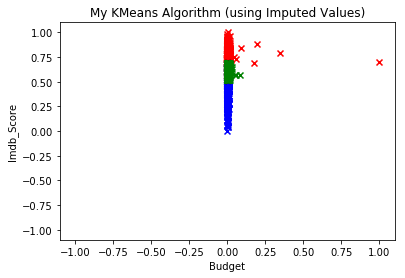

In [22]:
# Create our classifier
mc = MyKC(number_k=3)

# Train our classifier using the 'fit' method we defined above
imputedDFKMeans = imputedDF[['budget', 'imdb_score']]

mc.fit(imputedDFKMeans)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ MY K MEANS ALGORITHM ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
%matplotlib inline

plt.figure
count = 0
for i, c in zip(mc.clusters, ['red','blue', 'green']):
    # each 'i' is a cluster
    plt.plot(mc.init_p[count][0], mc.init_p[count][1], color=c,marker='o', markersize='7')
    for j in i:
        # each 'j' is a point in cluster 'i'
        plt.scatter(j[0],j[1], color=c, marker='x')
    count += 1
    
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.title('My KMeans Algorithm (using Imputed Values)')
plt.xlabel('Budget')
plt.ylabel('Imdb_Score')

plt.show



In [23]:
# We can see that typically Budget does not affect IMDB_Score as much as we would probably assume 


Trained!


<function matplotlib.pyplot.show>

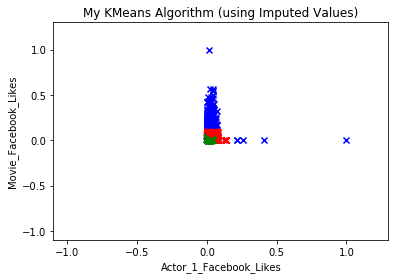

In [24]:
# Create our classifier
mc = MyKC(number_k=3)

# Train our classifier using the 'fit' method we defined above
imputedDFKMeans = imputedDF[['actor_1_facebook_likes', 'movie_facebook_likes']]

mc.fit(imputedDFKMeans)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ MY K MEANS ALGORITHM ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
%matplotlib inline

plt.figure
count = 0
for i, c in zip(mc.clusters, ['red','blue', 'green']):
    # each 'i' is a cluster
    plt.plot(mc.init_p[count][0], mc.init_p[count][1], color=c,marker='o', markersize='7')
    for j in i:
        # each 'j' is a point in cluster 'i'
        plt.scatter(j[0],j[1], color=c, marker='x')
    count += 1
    
plt.xlim([-1.1,1.3])
plt.ylim([-1.1,1.3])
plt.title('My KMeans Algorithm (using Imputed Values)')
plt.xlabel('Actor_1_Facebook_Likes')
plt.ylabel('Movie_Facebook_Likes')

plt.show



Trained!


<function matplotlib.pyplot.show>

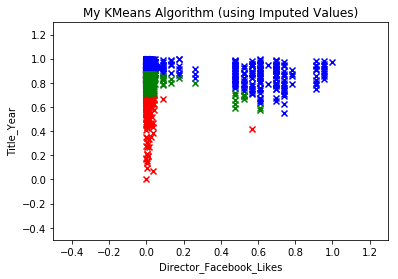

In [25]:
# Create our classifier
mc = MyKC(number_k=3)

# Train our classifier using the 'fit' method we defined above
imputedDFKMeans = imputedDF[['director_facebook_likes', 'title_year']]
mc.fit(imputedDFKMeans)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ MY K MEANS ALGORITHM ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
%matplotlib inline

plt.figure
count = 0
for i, c in zip(mc.clusters, ['red','blue', 'green']):
    # each 'i' is a cluster
    plt.plot(mc.init_p[count][0], mc.init_p[count][1], color=c,marker='o', markersize='7')
    for j in i:
        # each 'j' is a point in cluster 'i'
        plt.scatter(j[0],j[1], color=c, marker='x')
    count += 1
    
plt.xlim([-0.5,1.3])
plt.ylim([-0.5,1.3])
plt.title('My KMeans Algorithm (using Imputed Values)')
plt.xlabel('Director_Facebook_Likes')
plt.ylabel('Title_Year')

plt.show


In [26]:
# Here we see that Directors of more recent movies have more Facebook Likes
# We can attribute that to the recent development of Facebook and Social Media

Trained!


<function matplotlib.pyplot.show>

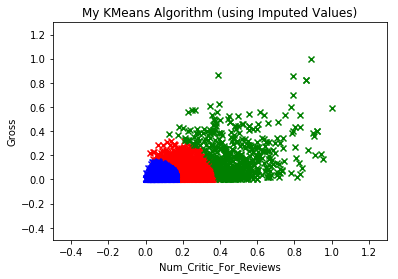

In [27]:
# Create our classifier
mc = MyKC(number_k=3)

# Train our classifier using the 'fit' method we defined above
imputedDFKMeans = imputedDF[['num_critic_for_reviews', 'gross']]
mc.fit(imputedDFKMeans)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ MY K MEANS ALGORITHM ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
%matplotlib inline

plt.figure
count = 0
for i, c in zip(mc.clusters, ['red','blue', 'green']):
    # each 'i' is a cluster
    plt.plot(mc.init_p[count][0], mc.init_p[count][1], color=c,marker='o', markersize='7')
    for j in i:
        # each 'j' is a point in cluster 'i'
        plt.scatter(j[0],j[1], color=c, marker='x')
    count += 1
    
plt.xlim([-0.5,1.3])
plt.ylim([-0.5,1.3])
plt.title('My KMeans Algorithm (using Imputed Values)')
plt.xlabel('Num_Critic_For_Reviews')
plt.ylabel('Gross')

plt.show


In [28]:
# Here we see that there is a correlation between the number of reviews by critics and the number of reviews by Users
# A higher amount of critic reviews means there is probably a higher amount of User Reviews

In [29]:
xC = imputedDF[:]
# yC = yImputed[:]
yC = y[:]



 
#split the data in to training and testing with a random state of 2.

xcTrain, xcTest, ycTrain, ycTest = train_test_split(xC, yC, test_size=0.4, random_state=2)


#Linear Regression object

myLinReg = LinearRegression()

myLinReg.fit(xcTrain, ycTrain)

# printing Theta0 using attribute "intercept_":
print(myLinReg.intercept_)

# printing [Theta1, Theta2, Theta3] using attribute "coef_":
print(myLinReg.coef_)
print(xC.columns)


# We see from the data that the highest absolute values for theta correspond to
# the 'actor_1_facebook_likes,' followed by 'cast_total_facebook_likes'

# And the worst is 'duration'


yPrediction = myLinReg.predict(xcTest)

# using rmse

# calculate the mean square error
mse = metrics.mean_squared_error(ycTest, yPrediction)

# using numpy to get the square root of the mse
rmse = np.sqrt(mse)

# print the rmse
print('RMSE:', rmse)

380253004.5
[ -2.23517418e-07  -6.70552254e-08  -9.68575478e-08  -1.56462193e-07
  -5.17815351e-07   4.88013029e-07   8.81031156e-07   2.23517418e-08
  -8.89413059e-08  -1.22934580e-07  -3.35276127e-08   1.49011612e-08
   8.38190317e-08   3.80252842e+08]
Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users',
       'cast_total_facebook_likes', 'num_user_for_reviews', 'budget',
       'title_year', 'actor_2_facebook_likes', 'imdb_score',
       'movie_facebook_likes', 'gross'],
      dtype='object')
RMSE: 8.65254412933e-08


/Users/edgar/Software/Jupyter/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [30]:
#using 10 fold fold validation

myLinRegCV = LinearRegression()

accuracyLinRegCV = cross_val_score(myLinRegCV, xC, yC, scoring='neg_mean_squared_error', cv=10)


mseScores = -accuracyLinRegCV
print(mseScores)

rmseCV = np.sqrt(mseScores)
print(rmseCV)
print('Mean RMSE scores: ', rmseCV.mean())

[  2.38793112e-14   4.32554425e-14   1.33203693e-14   1.88016990e-14
   1.11887411e-14   1.32280911e-14   1.53043523e-14   1.06858245e-14
   3.43044496e-15   5.50948176e-15]
[  1.54529322e-07   2.07979428e-07   1.15413904e-07   1.37119288e-07
   1.05776846e-07   1.15013439e-07   1.23710761e-07   1.03372262e-07
   5.85700005e-08   7.42258834e-08]
Mean RMSE scores:  1.19571113257e-07
